# Glory in Los Angeles: Machine Learning Predictions for the 2028 Olympic Medal Table

This is the final project of the course: Machine Leanring and Data Mining.

## Google Colab Setup
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

Then, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.
Run the following cell to mount your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the project:

In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the project
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '25MLDM'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['2025美赛C预测.pdf', '2025美赛C分析.pdf', 'summerOly_programs.csv', '2025美赛教练.pdf', 'summerOly_athletes.csv', '2025_MCM_Problem_C.pdf', 'summerOly_hosts.csv', 'analysis.py', '2025美赛证据.pdf', 'summerOly_medal_counts.csv', 'data_dictionary.csv', 'coach_effect.py', 'predict.py', 'analysis_results_with_residuals.csv', '.DS_Store', '结果分析', '结果', 'predict', '.git', 'analysis', 'evidence', 'coach', 'ML_Final_Project.ipynb']


In the very last step of the environment setup procedure, we need to go into the current directory by using the following command to go into the current folder, you can change the folder name and the path if you want.

In [3]:
# get into current path
%cd /content/drive/MyDrive/25MLDM/

/content/drive/MyDrive/25MLDM


In [4]:
!ls

2025_MCM_Problem_C.pdf		     evidence
2025美赛C分析.pdf		     ML_Final_Project.ipynb
2025美赛C预测.pdf		     predict
2025美赛教练.pdf		     predict.py
2025美赛证据.pdf		     summerOly_athletes.csv
analysis			     summerOly_hosts.csv
analysis.py			     summerOly_medal_counts.csv
analysis_results_with_residuals.csv  summerOly_programs.csv
coach				     结果
coach_effect.py			     结果分析
data_dictionary.csv


## Basic Setups

In the very first step, we are going to set up the basics of our project, including importing necessary packages, loading the data, and (maybe) the data visualization, in order to help us do better feature engineering.

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from numpy.random import default_rng
#from io import StringIO

In [6]:
# load the data
df_medals = pd.read_csv('summerOly_medal_counts.csv')
df_hosts = pd.read_csv('summerOly_hosts.csv')
df_athletes_raw = pd.read_csv('summerOly_athletes.csv')
print("data loading finish。")

data loading finish。


In [7]:
# data visualization
df_medals.head()

,Rank,NOC,Gold,Silver,Bronze,Total,Year
0,1,United States,11,7,2,20,1896
1,2,Greece,10,18,19,47,1896
2,3,Germany,6,5,2,13,1896
3,4,France,5,4,2,11,1896
4,5,Great Britain,2,3,2,7,1896


In [8]:
df_hosts.head()

,Year,Host
0,1896,"Athens, Greece"
1,1900,"Paris, France"
2,1904,"St. Louis, United States"
3,1908,"London, United Kingdom"
4,1912,"Stockholm, Sweden"


In [9]:
df_athletes_raw.head()

,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal
0,A Dijiang,M,China,CHN,1992,Barcelona,Basketball,Basketball Men's Basketball,No medal
1,A Lamusi,M,China,CHN,2012,London,Judo,Judo Men's Extra-Lightweight,No medal
2,Gunnar Aaby,M,Denmark,DEN,1920,Antwerpen,Football,Football Men's Football,No medal
3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Cornelia (-strannood),F,Netherlands,NED,1932,Los Angeles,Athletics,Athletics Women's 100 metres,No medal


## Feature Engineering Overview

This code prepares a clean and complete feature matrix for modeling Olympic medal outcomes.  
Because the raw datasets (athletes, medals, hosts) use inconsistent formats, several preprocessing steps are required.  
Below is a brief explanation of why each major step is necessary.

### 1. Mapping Country Names to NOC Codes
Different datasets refer to countries using different formats (full names vs. NOC codes).  
To merge all tables consistently, we extract country names from the athlete data and build a unified **Country → NOC** mapping.

### 2. Extracting Host Country NOC
Host information is given in text form (e.g., “Tokyo, Japan”).  
We extract the country part and convert it into a NOC code so we can add a reliable **Is_Host** feature later.

### 3. Computing Number of Athletes per Country per Year
The number of participating athletes is a strong indicator of medal performance.  
We aggregate athlete counts by (Year, NOC) to include this as a predictive feature.

### 4. Building a Complete Year–NOC Grid
Not all countries appear in every dataset, so we construct a full matrix of all combinations of years and NOCs.  
This ensures that:
- countries with zero medals are still represented,  
- future years (e.g., 2028) can be added for prediction.

### 5. Merging All Data Sources
Medal data, host data, and athlete counts are merged into the unified base table, producing a single modeling-ready dataframe.

### 6. Creating Lag Features
Performance in past Olympics is highly predictive of future success.  
We compute lagged medal counts (4-year and 8-year lags) to capture historical performance trends.

### 7. Computing Medal Shares
Absolute medal counts may be misleading due to variation across years.  
We compute each country’s share of total medals per Olympics to normalize performance differences.

---

Overall, this feature engineering pipeline produces a complete, consistent, and model-friendly dataset that captures historical trends, participation levels, host effects, and cross-year normalization.


In [10]:
# Feature Engineering
# ==================================
print("\n--- Step 2: Performing feature engineering... ---")

# --- Step 2a and 2b ---
print("Creating mapping: 'Country Name' -> 'NOC' ...")
df_athletes_raw['Country_Name'] = df_athletes_raw['Team'].apply(lambda x: x.split('-')[0])
country_to_noc_map = df_athletes_raw[['Country_Name', 'NOC']].drop_duplicates().set_index('Country_Name')['NOC'].to_dict()

print("Processing host country data and extracting NOC...")
df_hosts['Host_Country_Name'] = df_hosts['Host'].str.split(', ').str[-1]
df_hosts['Host_NOC'] = df_hosts['Host_Country_Name'].map(country_to_noc_map)

# --- Step 2c ---
print("Computing number of athletes per country per year from raw athlete data...")
df_athlete_counts = df_athletes_raw.groupby(['Year', 'NOC'])['Name'].nunique().reset_index()
df_athlete_counts.rename(columns={'Name': 'Num_Athletes'}, inplace=True)

# --- Step 2d ---
print("Building final feature matrix...")
# Combine athlete list and medal list to ensure all participating countries are included
all_nocs_medals = df_medals['NOC'].unique()
all_nocs_athletes = df_athletes_raw['NOC'].unique()
all_nocs = np.union1d(all_nocs_medals, all_nocs_athletes)

print(f"Identified {len(all_nocs)} participating countries/regions.")

all_years = np.unique(np.append(df_medals['Year'].unique(), df_hosts['Year'].unique()))
future_year = np.array([2028])
all_years_ext = np.unique(np.concatenate([all_years, future_year]))
df_base = pd.DataFrame([(year, noc) for year in all_years_ext for noc in all_nocs],
                       columns=['Year', 'NOC'])

# Merge all data sources sequentially
df_full = pd.merge(df_base, df_medals, on=['Year', 'NOC'], how='left')
df_full = pd.merge(df_full, df_hosts[['Year', 'Host_NOC']], on='Year', how='left')
df_full = pd.merge(df_full, df_athlete_counts, on=['Year', 'NOC'], how='left')

print("\nColumns of merged dataframe:", df_full.columns.tolist())

# Basic cleaning
df_full[['Gold', 'Total']] = df_full[['Gold', 'Total']].fillna(0)
df_full['Num_Athletes'] = df_full['Num_Athletes'].fillna(
    df_full.groupby('NOC')['Num_Athletes'].transform('mean')
).fillna(5)

df_full['Is_Host'] = (df_full['NOC'] == df_full['Host_NOC']).astype(int)

# Sorting + lag features
df_full = df_full.sort_values(by=['NOC', 'Year'])
for lag in [4, 8]:
    df_full[f'Gold_lag_{lag}'] = df_full.groupby('NOC')['Gold'].shift(int(lag/4))
    df_full[f'Total_lag_{lag}'] = df_full.groupby('NOC')['Total'].shift(int(lag/4))

for col in ['Gold_lag_4', 'Total_lag_4', 'Gold_lag_8', 'Total_lag_8']:
    df_full[col] = df_full[col].fillna(0)

# === Added: Compute per-Games medal share ===
print("Computing per-Olympics medal shares...")
df_full['Total_year_sum'] = df_full.groupby('Year')['Total'].transform('sum')
df_full['Gold_year_sum'] = df_full.groupby('Year')['Gold'].transform('sum')

df_full['Total_share'] = np.where(
    df_full['Total_year_sum'] > 0,
    df_full['Total'] / df_full['Total_year_sum'],
    0.0
)
df_full['Gold_share'] = np.where(
    df_full['Gold_year_sum'] > 0,
    df_full['Gold'] / df_full['Gold_year_sum'],
    0.0
)

print("\nFeature engineering completed.")



--- Step 2: Performing feature engineering... ---
Creating mapping: 'Country Name' -> 'NOC' ...
Processing host country data and extracting NOC...
Computing number of athletes per country per year from raw athlete data...
Building final feature matrix...
Identified 443 participating countries/regions.

Columns of merged dataframe: ['Year', 'NOC', 'Rank', 'Gold', 'Silver', 'Bronze', 'Total', 'Host_NOC', 'Num_Athletes']
Computing per-Olympics medal shares...

Feature engineering completed.


## Part 1: Olympic Medal Prediction

In [12]:
# 3. Model Training and Prediction (Predict shares, then multiply by total medals)
# ==================================
print("\n--- Step 3: Training share models and generating predictions... ---")

features = ['Year', 'Num_Athletes', 'Gold_lag_4', 'Total_lag_4',
            'Gold_lag_8', 'Total_lag_8', 'Is_Host']
df_full['NOC_cat'] = df_full['NOC'].astype('category').cat.codes
features_with_cat = features + ['NOC_cat']

# Training set: historical Olympics (Year < 2028)
X_train = df_full[df_full['Year'] < 2028].dropna(subset=features)
X_pred_2028 = df_full[df_full['Year'] == 2028][features_with_cat]

# Supervision targets: medal shares
y_train_gold_share = df_full.loc[X_train.index]['Gold_share']
y_train_total_share = df_full.loc[X_train.index]['Total_share']

# Train LightGBM share models
lgbm_gold_share = lgb.LGBMRegressor(random_state=42)
lgbm_gold_share.fit(
    X_train[features_with_cat], y_train_gold_share,
    feature_name=features_with_cat,
    categorical_feature=['NOC_cat']
)

lgbm_total_share = lgb.LGBMRegressor(random_state=42)
lgbm_total_share.fit(
    X_train[features_with_cat], y_train_total_share,
    feature_name=features_with_cat,
    categorical_feature=['NOC_cat']
)

# Predict shares for 2028
pred_gold_share_2028 = lgbm_gold_share.predict(X_pred_2028)
pred_total_share_2028 = lgbm_total_share.predict(X_pred_2028)

# Non-negativity + normalization (enforce share sum = 1)
pred_gold_share_2028 = np.clip(pred_gold_share_2028, 0, None)
pred_total_share_2028 = np.clip(pred_total_share_2028, 0, None)

if pred_gold_share_2028.sum() > 0:
    pred_gold_share_2028 = pred_gold_share_2028 / pred_gold_share_2028.sum()
else:
    pred_gold_share_2028 = np.ones_like(pred_gold_share_2028) / len(pred_gold_share_2028)

if pred_total_share_2028.sum() > 0:
    pred_total_share_2028 = pred_total_share_2028 / pred_total_share_2028.sum()
else:
    pred_total_share_2028 = np.ones_like(pred_total_share_2028) / len(pred_total_share_2028)

# Fix total medal count for 2028 (using 2024 totals as a proxy)
total_medals_2024 = df_medals[df_medals['Year'] == 2024]['Total'].sum()
gold_medals_2024 = df_medals[df_medals['Year'] == 2024]['Gold'].sum()

total_medals_2028 = total_medals_2024
gold_medals_2028 = gold_medals_2024

# Share × total medals = predicted medal counts (preserves total medal constraints)
pred_gold_2028 = pred_gold_share_2028 * gold_medals_2028
pred_total_2028 = pred_total_share_2028 * total_medals_2028

pred_gold_2028[pred_gold_2028 < 0] = 0
pred_total_2028[pred_total_2028 < 0] = 0

print("Share model training and initial predictions complete (total medals preserved).")



--- Step 3: Training share models and generating predictions... ---
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 14619, number of used features: 7
[LightGBM] [Info] Start training from score 0.002052
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wi

In [13]:
# 4. Uncertainty Quantification (Dirichlet + Monte Carlo)
# ==================================
print("\n--- Step 4: Quantifying uncertainty using Dirichlet + Monte Carlo... ---")

rng = default_rng(42)

mean_share_2028 = pred_total_share_2028.copy()

# Avoid zero Dirichlet parameters: apply small smoothing to shares, then renormalize
eps = 1e-6
mean_share_eps = mean_share_2028.copy()
mean_share_eps[mean_share_eps == 0] = eps
mean_share_eps = mean_share_eps / mean_share_eps.sum()

# Dirichlet concentration parameter (larger = more confident, narrower intervals)
kappa = 200.0
alpha_2028 = kappa * mean_share_eps  # Dirichlet parameters

num_samples = 5000
dirichlet_samples = rng.dirichlet(alpha_2028, size=num_samples)  # [num_samples, num_countries]

# Medal allocation for each sample (total medals strictly conserved each time)
samples_total_counts = dirichlet_samples * total_medals_2028
samples_total_counts = np.round(samples_total_counts)

# For each country, take 5% and 95% quantiles as a 90% prediction interval
pred_total_lower = np.percentile(samples_total_counts, 5, axis=0)
pred_total_upper = np.percentile(samples_total_counts, 95, axis=0)

print("Dirichlet-based 90% prediction intervals computed.")



--- Step 4: Quantifying uncertainty using Dirichlet + Monte Carlo... ---
Dirichlet-based 90% prediction intervals computed.



--- 步骤5: 正在整理并展示最终结果... ---

--- 2028年洛杉矶奥运会奖牌榜预测 (Top 10) ---
               NOC  Predicted_Gold  Predicted_Total 90%_Prediction_Interval  \
415  United States              38              102               [68, 141]   
90           China              35               87               [56, 122]   
159  Great Britain              20               72               [45, 106]   
136         France              18               57                [32, 86]   
204          Japan              19               51                [28, 80]   
155        Germany              18               50                [28, 77]   
23       Australia              16               49                [26, 76]   
279    Netherlands              14               39                [19, 64]   
197          Italy              14               33                [15, 57]   
86          Canada               5               29                [12, 51]   

     Change_vs_2024  
415           -24.0  
90             -4.0  


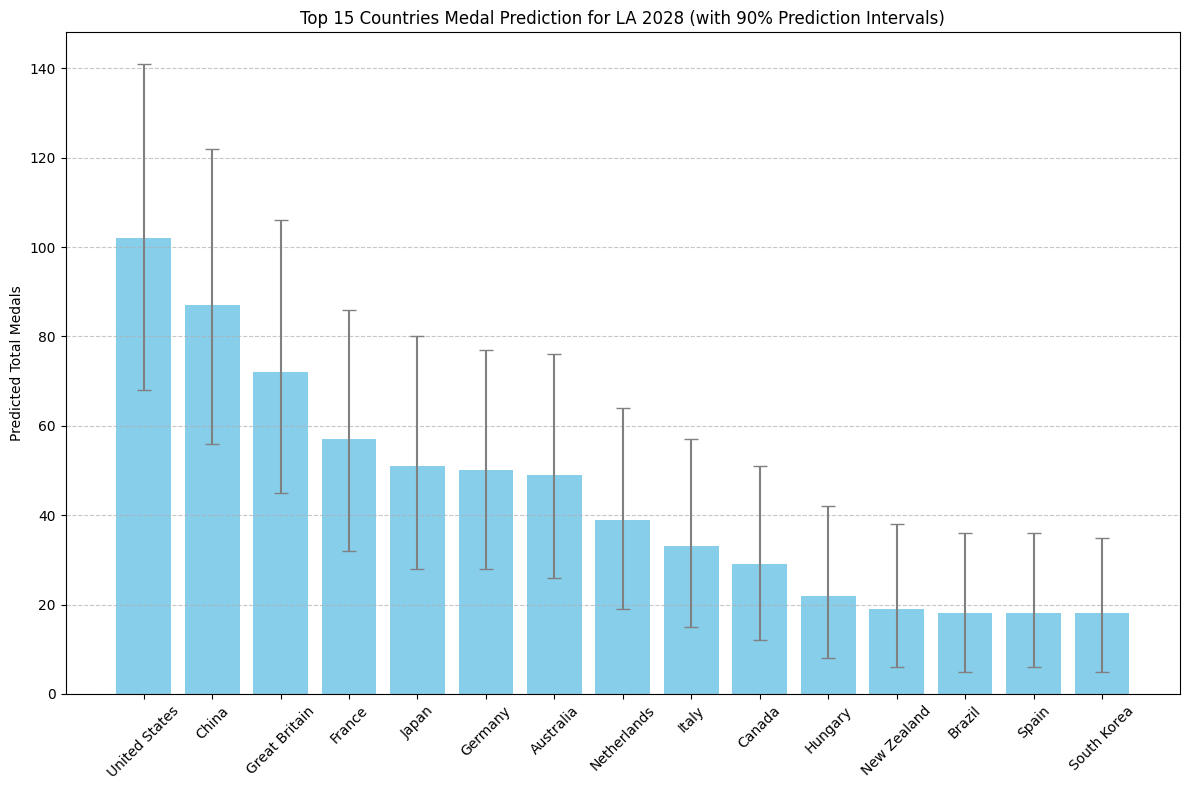

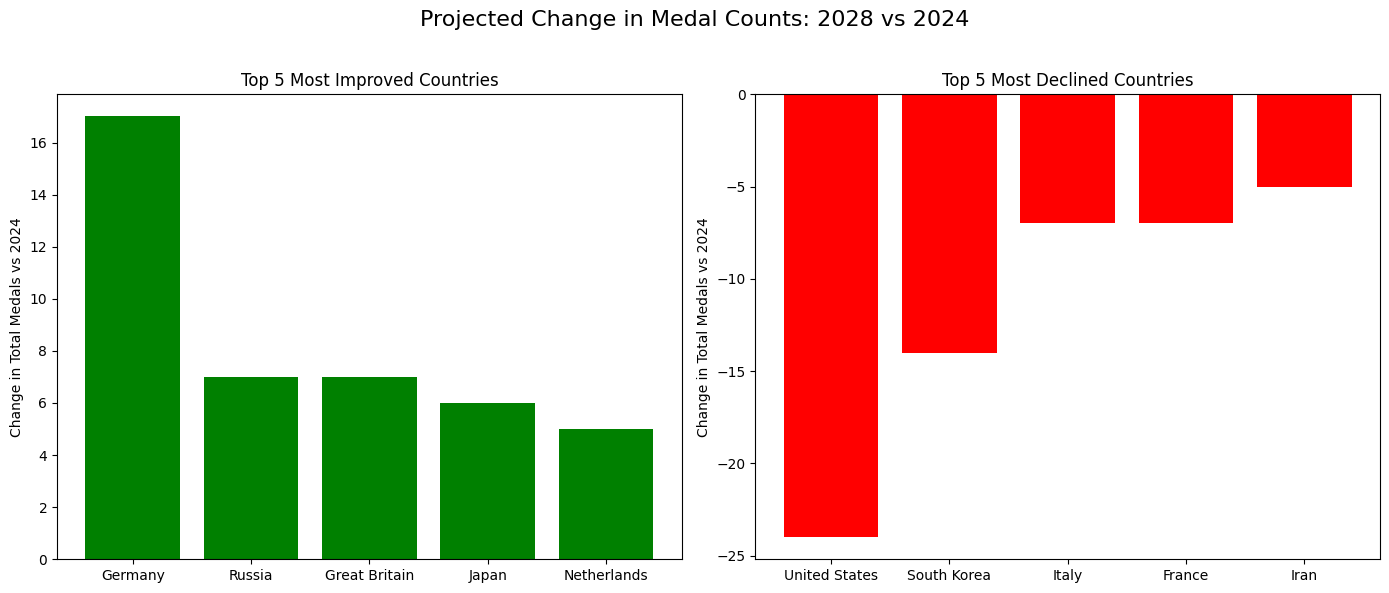


--- 步骤7: 正在评估份额模型表现 (Backtesting on 2024 data)... ---
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 14176, number of used features: 7
[LightGBM] [Info] Start training from score 0.002046

模型在2024年数据上的回测表现 (份额模型 → 奖牌数):
平均绝对误差 (MAE): 1.16 medals
均方根误差 (RMSE): 4.13 medals
解读: MAE表示，模型对2024年各国奖牌数的预测平均偏差为 1.16 枚奖牌。

正在生成模型表现的可视化图表...


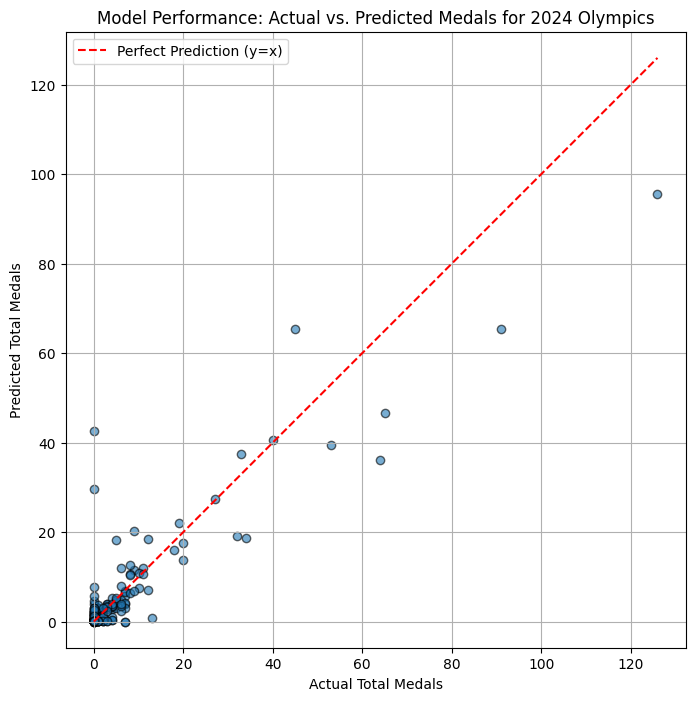

In [14]:
# 5. 结果展示
# ==================================
print("\n--- 步骤5: 正在整理并展示最终结果... ---")

df_results_2028 = df_full[df_full['Year'] == 2028][['NOC']].copy().reset_index(drop=True)

df_results_2028['Predicted_Gold'] = np.round(pred_gold_2028).astype(int)
df_results_2028['Predicted_Total'] = np.round(pred_total_2028).astype(int)
df_results_2028['Total_Lower_Bound'] = np.round(pred_total_lower).astype(int)
df_results_2028['Total_Upper_Bound'] = np.round(pred_total_upper).astype(int)

# 确保下界不高于预测值，上界不低于预测值
df_results_2028['Total_Lower_Bound'] = np.minimum(
    df_results_2028['Total_Lower_Bound'], df_results_2028['Predicted_Total']
)
df_results_2028['Total_Upper_Bound'] = np.maximum(
    df_results_2028['Total_Upper_Bound'], df_results_2028['Predicted_Total']
)

# 合并2024年数据以计算变化
df_2024 = df_medals[df_medals['Year'] == 2024][['NOC', 'Total']].rename(columns={'Total': 'Total_2024'})
df_results_2028 = pd.merge(df_results_2028, df_2024, on='NOC', how='left').fillna(0)
df_results_2028['Change_vs_2024'] = df_results_2028['Predicted_Total'] - df_results_2028['Total_2024']

# --- 最终结果表格输出 ---
print("\n--- 2028年洛杉矶奥运会奖牌榜预测 (Top 10) ---")
df_results_2028['90%_Prediction_Interval'] = df_results_2028.apply(
    lambda row: f"[{row['Total_Lower_Bound']}, {row['Total_Upper_Bound']}]", axis=1
)
print(df_results_2028.sort_values(by='Predicted_Total', ascending=False).head(10)[
    ['NOC', 'Predicted_Gold', 'Predicted_Total', '90%_Prediction_Interval', 'Change_vs_2024']
])

# --- 新增可视化函数 ---
def plot_top_n_predictions(results_df, n=15):
    """绘制Top N国家奖牌总数预测的条形图，并附上预测区间作为误差棒"""
    top_n = results_df.sort_values('Predicted_Total', ascending=False).head(n)
    plt.figure(figsize=(12, 8))

    lower_error = top_n['Predicted_Total'] - top_n['Total_Lower_Bound']
    upper_error = top_n['Total_Upper_Bound'] - top_n['Predicted_Total']
    error = [lower_error, upper_error]

    plt.bar(top_n['NOC'], top_n['Predicted_Total'], yerr=error, capsize=5, color='skyblue', ecolor='gray')

    plt.ylabel('Predicted Total Medals')
    plt.title(f'Top {n} Countries Medal Prediction for LA 2028 (with 90% Prediction Intervals)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_biggest_movers(results_df, n=5):
    """绘制奖牌数变化最大（上升和下降）国家的条形图"""
    sorted_df = results_df.sort_values('Change_vs_2024', ascending=False)

    improvers = sorted_df.head(n)
    decliners = sorted_df.tail(n).sort_values('Change_vs_2024', ascending=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.bar(improvers['NOC'], improvers['Change_vs_2024'], color='green')
    ax1.set_title(f'Top {n} Most Improved Countries')
    ax1.set_ylabel('Change in Total Medals vs 2024')

    ax2.bar(decliners['NOC'], decliners['Change_vs_2024'], color='red')
    ax2.set_title(f'Top {n} Most Declined Countries')
    ax2.set_ylabel('Change in Total Medals vs 2024')

    fig.suptitle('Projected Change in Medal Counts: 2028 vs 2024', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\n正在生成可视化图表...")
plot_top_n_predictions(df_results_2028)
plot_biggest_movers(df_results_2028)

# 7. 模型表现评估 (基于份额模型的回测)
# ==================================
print("\n--- 步骤7: 正在评估份额模型表现 (Backtesting on 2024 data)... ---")
from sklearn.metrics import mean_absolute_error, mean_squared_error

validation_year = 2024

# 训练数据：validation_year 之前的所有届
X_train_eval = df_full[df_full['Year'] < validation_year].dropna(subset=features)
y_train_eval_share = df_full.loc[X_train_eval.index]['Total_share']

X_validation = df_full[df_full['Year'] == validation_year][features_with_cat]
y_actual_validation_total = df_full.loc[X_validation.index]['Total']

eval_model_share = lgb.LGBMRegressor(random_state=42)
eval_model_share.fit(
    X_train_eval[features_with_cat], y_train_eval_share,
    feature_name=features_with_cat,
    categorical_feature=['NOC_cat']
)

# 对 2024 年预测 share
y_pred_share_validation = eval_model_share.predict(X_validation[features_with_cat])
y_pred_share_validation = np.clip(y_pred_share_validation, 0, None)

if y_pred_share_validation.sum() > 0:
    y_pred_share_validation = y_pred_share_validation / y_pred_share_validation.sum()
else:
    y_pred_share_validation = np.ones_like(y_pred_share_validation) / len(y_pred_share_validation)

total_medals_2024 = df_medals[df_medals['Year'] == 2024]['Total'].sum()
y_pred_validation = y_pred_share_validation * total_medals_2024
y_pred_validation[y_pred_validation < 0] = 0

mae = mean_absolute_error(y_actual_validation_total, y_pred_validation)
rmse = np.sqrt(mean_squared_error(y_actual_validation_total, y_pred_validation))

print(f"\n模型在2024年数据上的回测表现 (份额模型 → 奖牌数):")
print(f"平均绝对误差 (MAE): {mae:.2f} medals")
print(f"均方根误差 (RMSE): {rmse:.2f} medals")
print(f"解读: MAE表示，模型对2024年各国奖牌数的预测平均偏差为 {mae:.2f} 枚奖牌。")

def plot_actual_vs_predicted(y_actual, y_predicted, year):
    """绘制一个散点图，比较模型的预测值与真实值"""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_actual, y_predicted, alpha=0.6, edgecolors='k')

    perfect_line = np.linspace(
        min(y_actual.min(), y_predicted.min()),
        max(y_actual.max(), y_predicted.max()), 100
    )
    plt.plot(perfect_line, perfect_line, 'r--', label='Perfect Prediction (y=x)')

    plt.xlabel("Actual Total Medals")
    plt.ylabel("Predicted Total Medals")
    plt.title(f"Model Performance: Actual vs. Predicted Medals for {year} Olympics")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

print("\n正在生成模型表现的可视化图表...")
eval_results = pd.DataFrame({
    'Actual': y_actual_validation_total,
    'Predicted': y_pred_validation
})
plot_actual_vs_predicted(eval_results['Actual'], eval_results['Predicted'], validation_year)

However, we find that our prediction for most small countries (which is always having Olympic medals) are fine, for the big countries, they are always underestimated



#

# GDP与人口对奖牌数影响的相关性分析

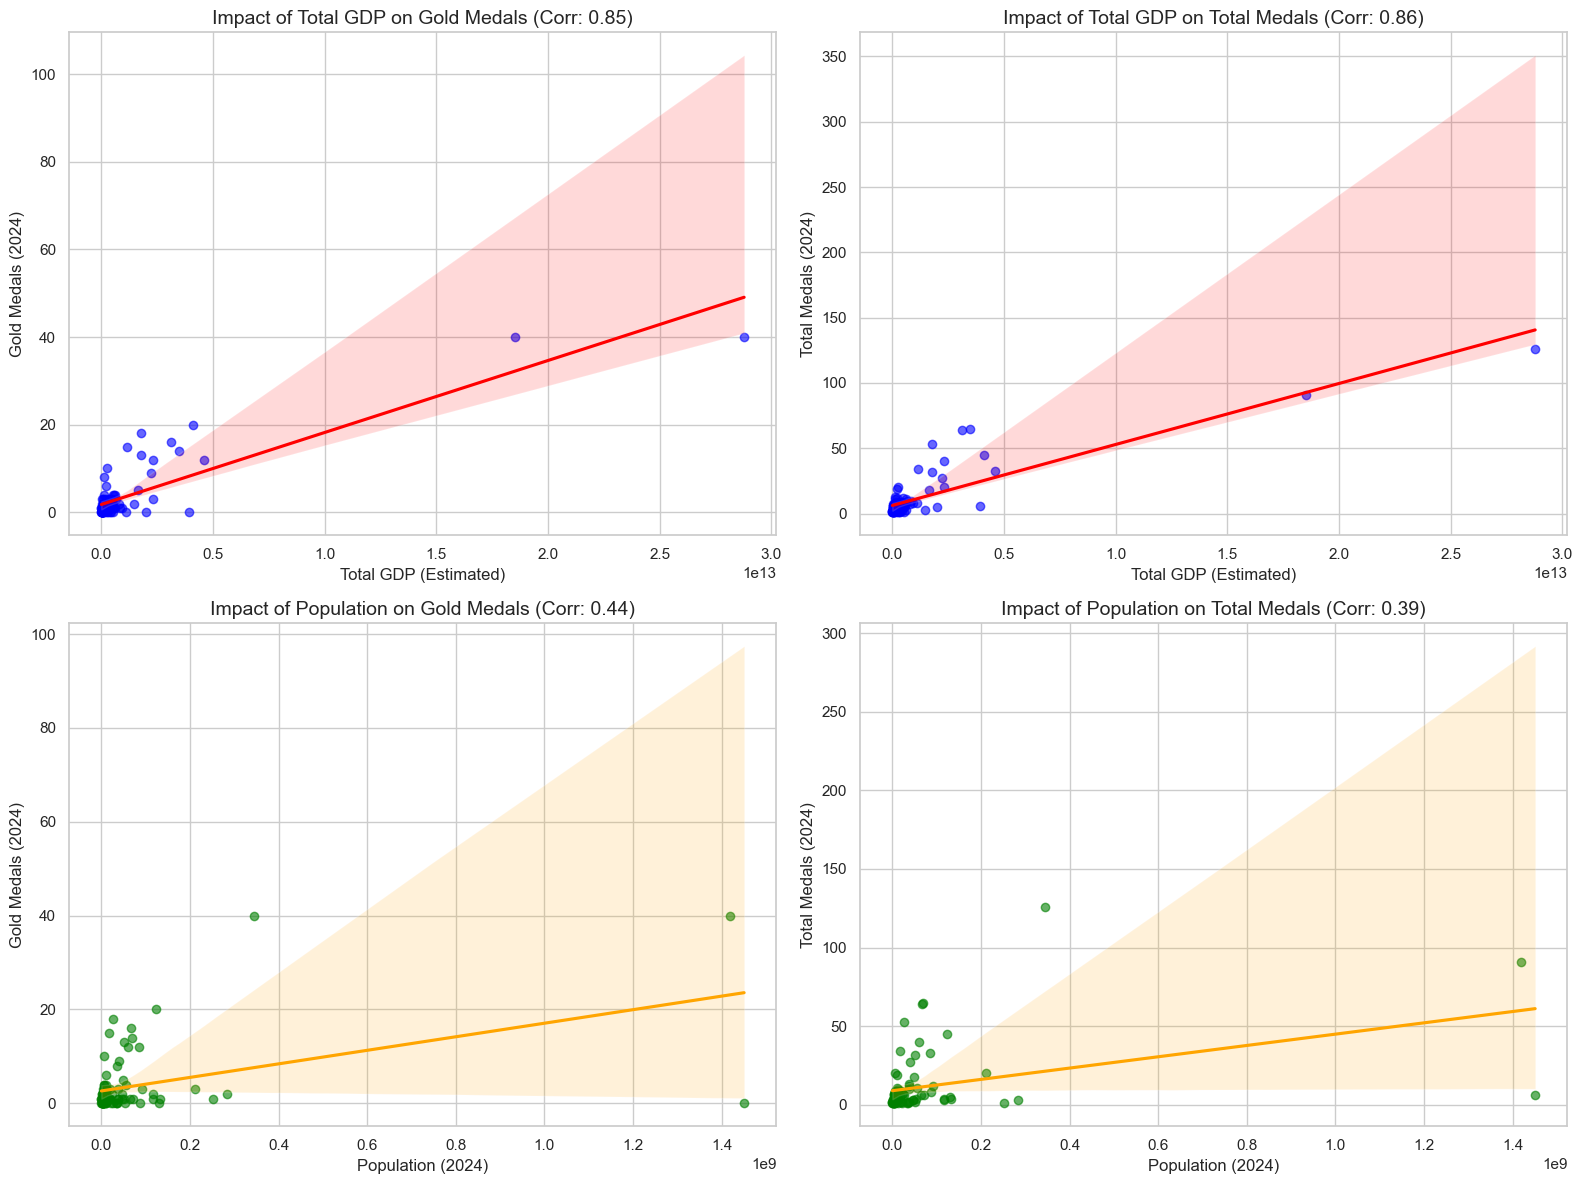

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read data
# Ensure the csv file is in the current directory or provide the correct path
df = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')

# 2. Data Processing
# Calculate Total Medals 2024
df['Total Medals 2024'] = df['Gold 2024'] + df['Silver 2024'] + df['Bronze 2024']

# Calculate Total GDP Estimate
# 'GDP 2024' is likely per capita, so multiply by population to get total economic size
df['Total GDP Estimate'] = df['Population 2024'] * df['GDP 2024']

# 3. Plotting Setup
sns.set(style="whitegrid")
# Default font works well for English
plt.rcParams['font.family'] = 'sans-serif' 

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Analysis A: Total GDP vs Medals ---

# Plot 1: Total GDP vs Gold Medals
sns.regplot(x='Total GDP Estimate', y='Gold 2024', data=df, ax=axes[0, 0], 
            scatter_kws={'alpha':0.6, 'color': 'blue'}, line_kws={'color':'red'})
corr_gdp_gold = df['Total GDP Estimate'].corr(df['Gold 2024'])
axes[0, 0].set_title(f'Impact of Total GDP on Gold Medals (Corr: {corr_gdp_gold:.2f})', fontsize=14)
axes[0, 0].set_xlabel('Total GDP (Estimated)', fontsize=12)
axes[0, 0].set_ylabel('Gold Medals (2024)', fontsize=12)

# Plot 2: Total GDP vs Total Medals
sns.regplot(x='Total GDP Estimate', y='Total Medals 2024', data=df, ax=axes[0, 1], 
            scatter_kws={'alpha':0.6, 'color': 'blue'}, line_kws={'color':'red'})
corr_gdp_total = df['Total GDP Estimate'].corr(df['Total Medals 2024'])
axes[0, 1].set_title(f'Impact of Total GDP on Total Medals (Corr: {corr_gdp_total:.2f})', fontsize=14)
axes[0, 1].set_xlabel('Total GDP (Estimated)', fontsize=12)
axes[0, 1].set_ylabel('Total Medals (2024)', fontsize=12)


# --- Analysis B: Population vs Medals ---

# Plot 3: Population vs Gold Medals
sns.regplot(x='Population 2024', y='Gold 2024', data=df, ax=axes[1, 0], 
            scatter_kws={'alpha':0.6, 'color': 'green'}, line_kws={'color':'orange'})
corr_pop_gold = df['Population 2024'].corr(df['Gold 2024'])
axes[1, 0].set_title(f'Impact of Population on Gold Medals (Corr: {corr_pop_gold:.2f})', fontsize=14)
axes[1, 0].set_xlabel('Population (2024)', fontsize=12)
axes[1, 0].set_ylabel('Gold Medals (2024)', fontsize=12)

# Plot 4: Population vs Total Medals
sns.regplot(x='Population 2024', y='Total Medals 2024', data=df, ax=axes[1, 1], 
            scatter_kws={'alpha':0.6, 'color': 'green'}, line_kws={'color':'orange'})
corr_pop_total = df['Population 2024'].corr(df['Total Medals 2024'])
axes[1, 1].set_title(f'Impact of Population on Total Medals (Corr: {corr_pop_total:.2f})', fontsize=14)
axes[1, 1].set_xlabel('Population (2024)', fontsize=12)
axes[1, 1].set_ylabel('Total Medals (2024)', fontsize=12)

# Adjust layout and show
plt.tight_layout()
plt.show()

# 国际奥委会决策建议 (基于 UCB 算法)

=== 国际奥委会决策建议 (基于 UCB 算法) ===
      country  Has_Hosted  Mu_Capability  Sigma  Score_UCB
United States           1       0.971121   0.05   1.021121
  New Zealand           0       0.639075   0.25   0.889075
        China           1       0.832384   0.05   0.882384
Great Britain           1       0.831767   0.05   0.881767
       France           1       0.825039   0.05   0.875039
    Australia           1       0.809416   0.05   0.859416
      Hungary           0       0.594582   0.25   0.844582
  Switzerland           0       0.565305   0.25   0.815305
        Japan           1       0.761323   0.05   0.811323
       Norway           0       0.554456   0.25   0.804456


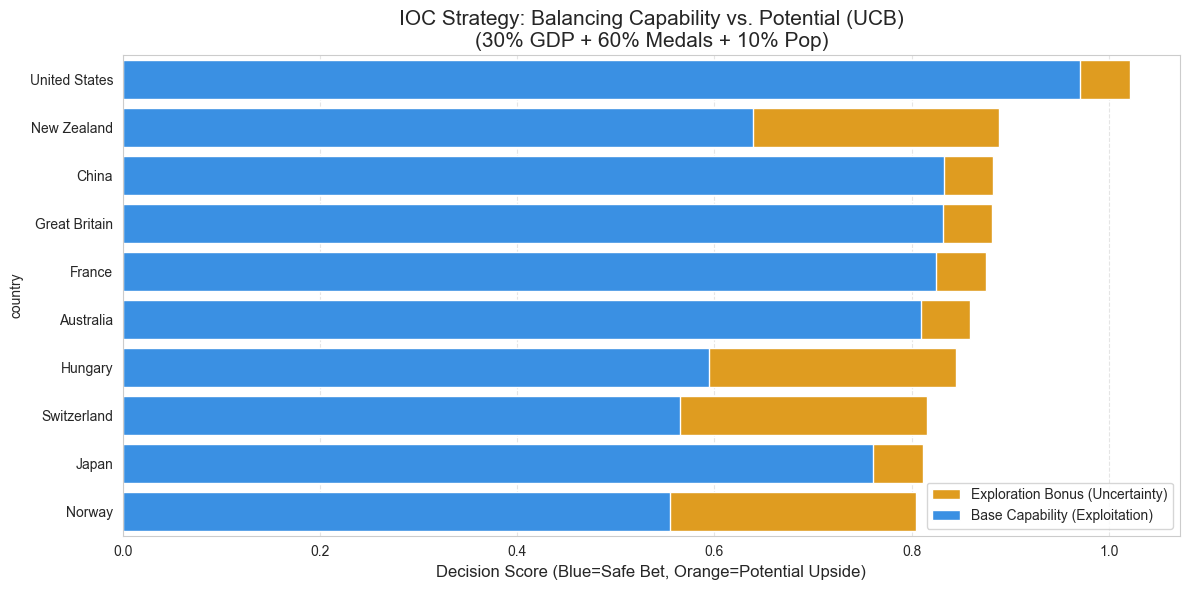

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. 数据准备与特征工程
# ==========================================
# 加载数据
df_gdp = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')
df_hosts = pd.read_csv('summerOly_hosts.csv')

# 计算 2024 总奖牌数
df_gdp['Total_Medals_2024'] = df_gdp['Gold 2024'] + df_gdp['Silver 2024'] + df_gdp['Bronze 2024']

# --- 关键步骤：定义谁是"已知宿主"(Has Hosted) ---
# 需要处理国家名称的不一致 (如 "United States" vs "St. Louis, United States")
host_mapping = {
    'United States': 'United States', 'Great Britain': 'United Kingdom',
    'United Kingdom': 'United Kingdom', 'China': 'China', 'France': 'France',
    'Japan': 'Japan', 'Germany': 'Germany', 'Australia': 'Australia',
    'Greece': 'Greece', 'Sweden': 'Sweden', 'Belgium': 'Belgium',
    'Netherlands': 'Netherlands', 'Finland': 'Finland', 'Italy': 'Italy',
    'Mexico': 'Mexico', 'Canada': 'Canada', 'Russia': 'Russia',
    'South Korea': 'South Korea', 'Korea': 'South Korea', 'Spain': 'Spain',
    'Brazil': 'Brazil'
}

# 提取主办国名单
def clean_host_country(s):
    if not isinstance(s, str): return ''
    for k, v in host_mapping.items():
        if k in s or v in s: return v
    return s.split(',')[-1].strip()

df_hosts['Clean_Host'] = df_hosts['Host'].apply(clean_host_country)
past_hosts = set(df_hosts['Clean_Host'].unique())

# 标记候选国状态
df_gdp['Mapped_Country'] = df_gdp['country'].map(host_mapping).fillna(df_gdp['country'])
df_gdp['Has_Hosted'] = df_gdp['Mapped_Country'].apply(lambda x: 1 if x in past_hosts else 0)

# ==========================================
# 2. 建模：构建回报函数 (Reward Function)
# ==========================================
# 我们定义 "Capability (Mu)" 为国家的客观硬实力。
# 公式：Mu = 30% 经济 + 60% 体育 + 10% 人口潜力
# 权重分配反映评价优先级：优先体育强国（60%），兼顾经济能力（30%），适度考虑人口潜力（10%）
# 使用 Log 变换处理 GDP 和人口的巨大差异 (Power Law)

scaler = MinMaxScaler()
df_gdp['Log_GDP'] = np.log1p(df_gdp['GDP 2024'])
df_gdp['Log_Pop'] = np.log1p(df_gdp['Population 2024'])
df_gdp['Log_Medals'] = np.log1p(df_gdp['Total_Medals_2024'])

# 归一化到 0-1 之间
df_gdp['Norm_GDP'] = scaler.fit_transform(df_gdp[['Log_GDP']])
df_gdp['Norm_Pop'] = scaler.fit_transform(df_gdp[['Log_Pop']])
df_gdp['Norm_Medals'] = scaler.fit_transform(df_gdp[['Log_Medals']])

# 计算预期收益 (Mean Expected Reward)
df_gdp['Mu_Capability'] = (0.3 * df_gdp['Norm_GDP'] + 
                           0.6 * df_gdp['Norm_Medals'] + 
                           0.1 * df_gdp['Norm_Pop'])

# ==========================================
# 3. 建模：定义不确定性 (Uncertainty / Risk)
# ==========================================
# 核心假设：
# - 举办过(Hosted=1): 不确定性低 (Sigma = 0.05)。我们知道他们能办好。
# - 未举办过(Hosted=0): 不确定性高 (Sigma = 0.25)。可能是巨大的成功，也可能是灾难。
df_gdp['Sigma'] = df_gdp['Has_Hosted'].apply(lambda x: 0.05 if x == 1 else 0.25)

# ==========================================
# 4. 实施决策策略 (Bandit Policies)
# ==========================================

# --- 策略: UCB (Upper Confidence Bound) ---
# Score = Mean + c * Sigma
# 我们给予不确定性奖励，鼓励探索未知
exploration_weight = 1.0
df_gdp['Score_UCB'] = df_gdp['Mu_Capability'] + exploration_weight * df_gdp['Sigma']

# ==========================================
# 5. 结果展示
# ==========================================
cols = ['country', 'Has_Hosted', 'Mu_Capability', 'Sigma', 'Score_UCB']
top_candidates = df_gdp.sort_values('Score_UCB', ascending=False).head(10)

print("=== 国际奥委会决策建议 (基于 UCB 算法) ===")
print(top_candidates[cols].to_string(index=False))

# 可视化：展示 "Exploitation" (蓝色) vs "Exploration Bonus" (橙色)
plt.figure(figsize=(12, 6))
# 底层：总分 (包含探索红利)
sns.barplot(data=top_candidates, x='Score_UCB', y='country', color='orange', label='Exploration Bonus (Uncertainty)')
# 顶层：基础能力 (仅利用)
sns.barplot(data=top_candidates, x='Mu_Capability', y='country', color='dodgerblue', label='Base Capability (Exploitation)')

plt.title('IOC Strategy: Balancing Capability vs. Potential (UCB)\n(30% GDP + 60% Medals + 10% Pop)', fontsize=15)
plt.xlabel('Decision Score (Blue=Safe Bet, Orange=Potential Upside)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2028年2032年举办国家预测（基于UCB算法）


=== 2028 Perdiction ===

2028 Winner prediction: Australia (Oceania)
2028 Score: 0.967


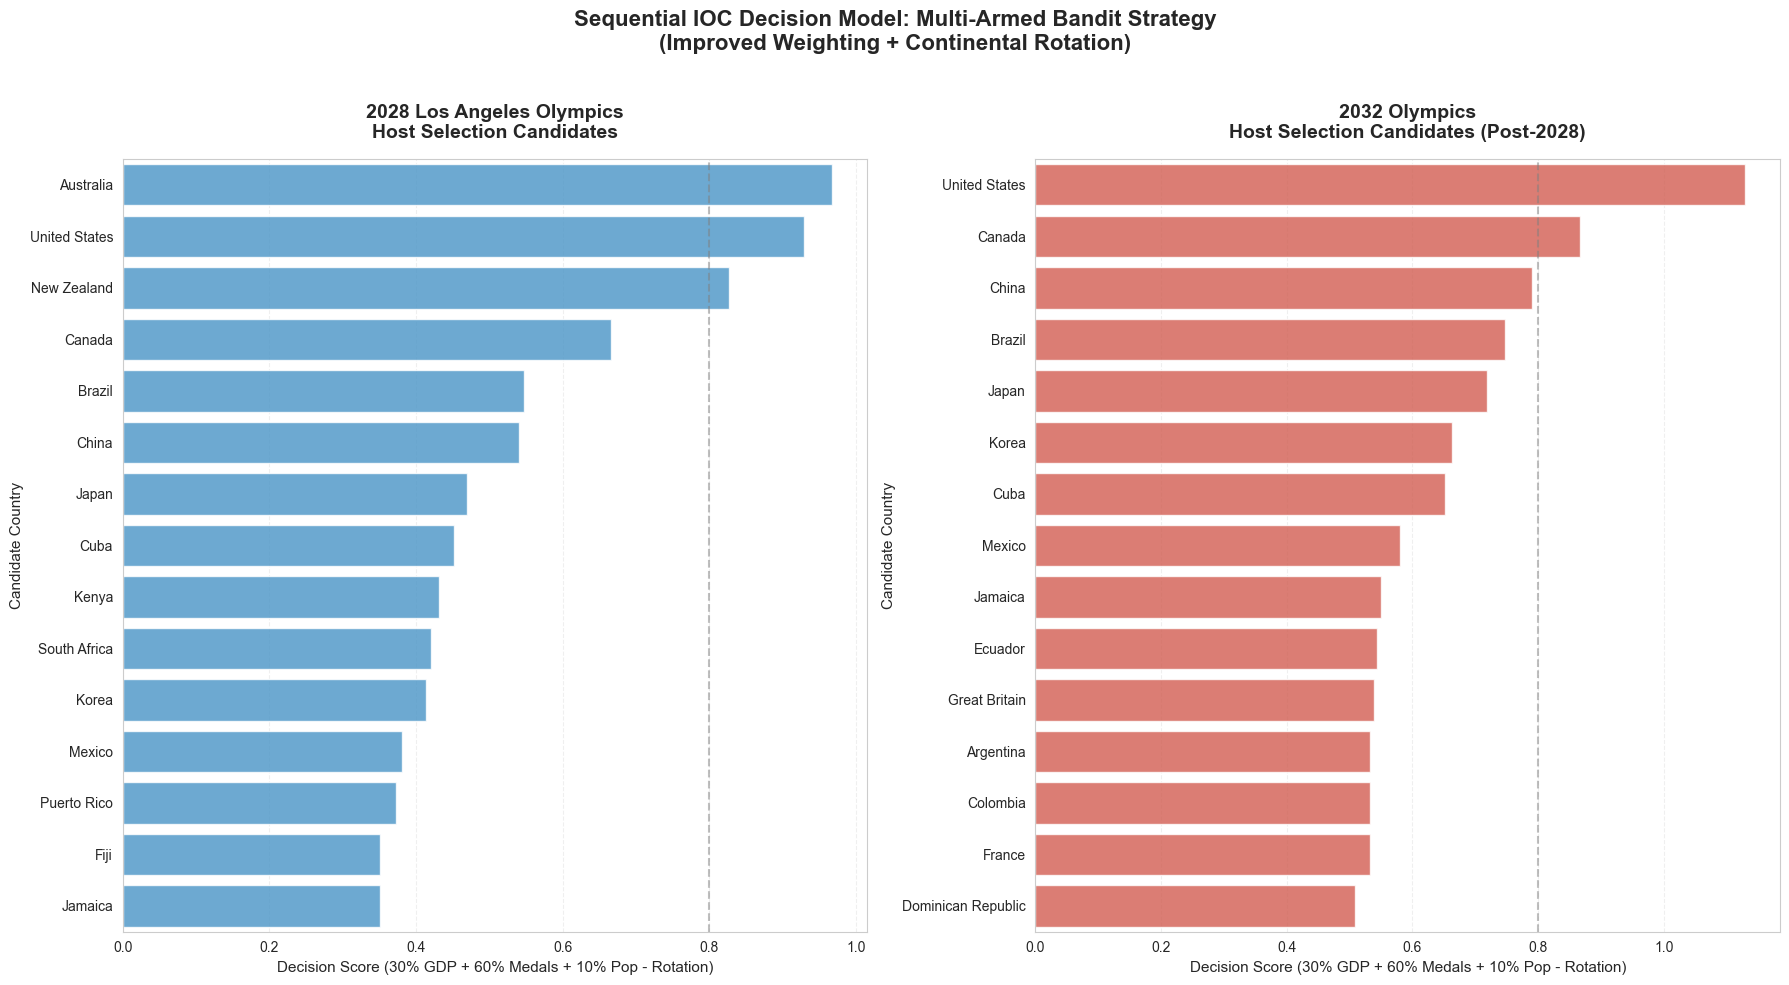


=== 2032 Perdiction ===
2032 Winner prediction: United States (Americas)
2032 Score: 1.129

Rotation effect: Oceania (2028) → Americas (2032)


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. 数据准备 (Data Prep)
# ==========================================
# 加载您的数据
df_gdp = pd.read_csv('medals_population_gdp_2024_2004_processed.csv')
df_hosts = pd.read_csv('summerOly_hosts.csv')

# 简单的特征工程：计算总奖牌
df_gdp['Total_Medals_2024'] = df_gdp['Gold 2024'] + df_gdp['Silver 2024'] + df_gdp['Bronze 2024']

# --- 核心：建立大洲映射 (Continental Mapping) - 完善版（排除非洲） ---
# 这是轮换规则的基础
continent_map = {
    # 欧洲 (Europe) - 完整覆盖
    'United Kingdom': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
    'Italy': 'Europe', 'Spain': 'Europe', 'Greece': 'Europe',
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Sweden': 'Europe',
    'Norway': 'Europe', 'Denmark': 'Europe', 'Finland': 'Europe',
    'Poland': 'Europe', 'Switzerland': 'Europe', 'Austria': 'Europe',
    'Czechia': 'Europe', 'Czech Republic': 'Europe', 'Hungary': 'Europe',
    'Romania': 'Europe', 'Croatia': 'Europe', 'Portugal': 'Europe',
    'Ireland': 'Europe', 'Serbia': 'Europe', 'Bulgaria': 'Europe',
    'Slovakia': 'Europe', 'Slovenia': 'Europe', 'Lithuania': 'Europe',
    'Estonia': 'Europe', 'Latvia': 'Europe', 'Ukraine': 'Europe',
    'Belarus': 'Europe', 'Georgia': 'Europe', 'Armenia': 'Europe',
    'Azerbaijan': 'Europe', 'Türkiye': 'Europe', 'Turkey': 'Europe',
    'Russia': 'Europe', 'Russian Federation': 'Europe', 'ROC': 'Europe',
    'Great Britain': 'Europe', 'Luxembourg': 'Europe', 'Cyprus': 'Europe',
    'Malta': 'Europe', 'Iceland': 'Europe', 'Moldova': 'Europe',
    'Albania': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Montenegro': 'Europe',
    'North Macedonia': 'Europe', 'Kosovo': 'Europe', 'San Marino': 'Europe',
    
    # 亚洲 (Asia) - 完整覆盖
    'China': 'Asia', "People's Republic of China": 'Asia',
    'Japan': 'Asia', 'South Korea': 'Asia', 'Korea': 'Asia',
    'India': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia',
    'IR Iran': 'Asia', 'Iran': 'Asia', 'Kazakhstan': 'Asia',
    'Chinese Taipei': 'Asia', 'Taiwan': 'Asia',
    'Hong Kong, China': 'Asia', 'Hong Kong': 'Asia',
    'Israel': 'Asia', 'Saudi Arabia': 'Asia', 'Qatar': 'Asia',
    'United Arab Emirates': 'Asia', 'UAE': 'Asia',
    'Singapore': 'Asia', 'Malaysia': 'Asia', 'Vietnam': 'Asia',
    'Philippines': 'Asia', 'Pakistan': 'Asia', 'Bangladesh': 'Asia',
    'Sri Lanka': 'Asia', 'Myanmar': 'Asia', 'Cambodia': 'Asia',
    'Laos': 'Asia', 'Mongolia': 'Asia', 'Uzbekistan': 'Asia',
    'Kyrgyzstan': 'Asia', 'Tajikistan': 'Asia', 'Turkmenistan': 'Asia',
    'Afghanistan': 'Asia', 'Nepal': 'Asia', 'Bhutan': 'Asia',
    'Jordan': 'Asia', 'Lebanon': 'Asia', 'Syria': 'Asia',
    'Iraq': 'Asia', 'Kuwait': 'Asia', 'Bahrain': 'Asia',
    'Oman': 'Asia', 'Yemen': 'Asia', 'Maldives': 'Asia',
    
    # 美洲 (Americas) - 完整覆盖
    'United States': 'Americas', 'USA': 'Americas', 'US': 'Americas',
    'Canada': 'Americas', 'Brazil': 'Americas', 'Mexico': 'Americas',
    'Argentina': 'Americas', 'Cuba': 'Americas', 'Colombia': 'Americas',
    'Chile': 'Americas', 'Peru': 'Americas', 'Jamaica': 'Americas',
    'Ecuador': 'Americas', 'Venezuela': 'Americas', 'Guatemala': 'Americas',
    'Dominican Republic': 'Americas', 'Costa Rica': 'Americas',
    'Panama': 'Americas', 'Uruguay': 'Americas', 'Bolivia': 'Americas',
    'Paraguay': 'Americas', 'El Salvador': 'Americas', 'Honduras': 'Americas',
    'Nicaragua': 'Americas', 'Trinidad and Tobago': 'Americas',
    'Bahamas': 'Americas', 'Barbados': 'Americas', 'Grenada': 'Americas',
    'Saint Lucia': 'Americas', 'Saint Kitts and Nevis': 'Americas',
    'Dominica': 'Americas', 'Antigua and Barbuda': 'Americas',
    'Saint Vincent and the Grenadines': 'Americas', 'Belize': 'Americas',
    'Guyana': 'Americas', 'Suriname': 'Americas', 'Haiti': 'Americas',
    
    # 大洋洲 (Oceania) - 完整覆盖
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'Fiji': 'Oceania', 'Papua New Guinea': 'Oceania',
    'Samoa': 'Oceania', 'Tonga': 'Oceania', 'Vanuatu': 'Oceania',
    'Solomon Islands': 'Oceania', 'Kiribati': 'Oceania',
    'Micronesia': 'Oceania', 'Palau': 'Oceania', 'Marshall Islands': 'Oceania',
    'Nauru': 'Oceania', 'Tuvalu': 'Oceania', 'Cook Islands': 'Oceania',
    
    # 非洲国家不纳入轮换考量，映射到 Others
    # (如需要可以单独处理，但本次分析中将非洲排除在外)
}

# 处理国家名映射
host_mapping = {
    'United States': 'United States', 'Great Britain': 'United Kingdom', 
    'United Kingdom': 'United Kingdom', 'China': 'China', 'France': 'France', 
    'Japan': 'Japan', 'Germany': 'Germany', 'Australia': 'Australia',
    'Russia': 'Russia', 'South Korea': 'South Korea', 'Korea': 'South Korea', 
    'Brazil': 'Brazil', 'Spain': 'Spain', 'Greece': 'Greece',
    'Sweden': 'Sweden', 'Belgium': 'Belgium', 'Netherlands': 'Netherlands',
    'Finland': 'Finland', 'Italy': 'Italy', 'Mexico': 'Mexico',
    'Canada': 'Canada', 'New Zealand': 'New Zealand'
}

df_gdp['Mapped_Country'] = df_gdp['country'].map(host_mapping).fillna(df_gdp['country'])
df_gdp['Continent'] = df_gdp['Mapped_Country'].map(continent_map).fillna('Others')

# 标记是否举办过 (Has_Hosted)
def clean_host_country(s):
    if not isinstance(s, str): return ''
    for k, v in host_mapping.items():
        if k in s or v in s: return v
    return s.split(',')[-1].strip()

df_hosts['Clean_Host'] = df_hosts['Host'].apply(clean_host_country)
past_hosts = set(df_hosts['Clean_Host'].unique())
df_gdp['Has_Hosted'] = df_gdp['Mapped_Country'].apply(lambda x: 1 if x in past_hosts else 0)

# ==========================================
# 2. 计算硬实力 (Mu Capability) - 优化权重
# ==========================================
scaler = MinMaxScaler()
# 对数变换 + 归一化
for col in ['GDP 2024', 'Population 2024', 'Total_Medals_2024']:
    df_gdp[f'Norm_{col}'] = scaler.fit_transform(np.log1p(df_gdp[[col]]))

# 硬实力公式优化：30%经济 + 60%体育 + 10%人口
# 提高GDP权重，使经济实力强的国家（如美国）更有优势
df_gdp['Mu_Capability'] = (0.3 * df_gdp['Norm_GDP 2024'] + 
                           0.6 * df_gdp['Norm_Total_Medals_2024'] + 
                           0.1 * df_gdp['Norm_Population 2024'])

# ==========================================
# 3. 动态预测函数 (Sequential Prediction) - 优化惩罚
# ==========================================
def run_ioc_simulation(prev_history, df_input, year_label):
    df = df_input.copy()
    
    # 定义轮换惩罚 (Continental Rotation Penalty) - 优化版
    def get_penalty(cont):
        # Others（未分类/非洲）：不给惩罚，也不给奖励（中性处理）
        if cont == 'Others': 
            return 0.0
        
        # 刚办完 (Penalty 1.0 = 绝对排除)
        if len(prev_history) > 0 and cont == prev_history[0]: 
            return 1.0
        # 两届前 (Penalty 0.3 = 很难)
        if len(prev_history) > 1 and cont == prev_history[1]: 
            return 0.3
        # 三届前 (Penalty 0.05 = 轻微疲劳，已较远)
        if len(prev_history) > 2 and cont == prev_history[2]: 
            return 0.05
        
        # 长期未办的大洲给予较大奖励（鼓励多样性和公平轮换）
        # 澳大利亚2000年办过，但Oceania自那以后就没办过了
        if cont not in prev_history:
            return -0.15  # 负惩罚 = 15% 加成（大洲轮换红利）
        
        return 0.0

    df['Geo_Penalty'] = df['Continent'].apply(get_penalty)
    
    # 定义不确定性 (Sigma): 没办过的给高分
    df['Sigma'] = df['Has_Hosted'].apply(lambda x: 0.05 if x == 1 else 0.25)
    
    # 计算最终得分 (Score) - 保守策略 (探索权重=0.15)
    df['Score'] = df['Mu_Capability'] + (0.15 * df['Sigma']) - df['Geo_Penalty']
    
    # 整理结果
    df['Simulation_Year'] = year_label
    return df.sort_values('Score', ascending=False)

# ==========================================
# 4. 执行两轮预测
# ==========================================

# --- 第一轮: 2028 ---
# 历史背景: [2024欧洲, 2020亚洲, 2016美洲]
history_2028 = ['Europe', 'Asia', 'Americas']
results_2028 = run_ioc_simulation(history_2028, df_gdp, '2028 Prediction')
winner_2028 = results_2028.iloc[0] # 获取赢家

# --- 第二轮: 2032 ---
# 关键步骤：把 2028 的赢家的大洲加到历史列表的最前面！
# 新历史背景: [2028美洲, 2024欧洲, 2020亚洲]
history_2032 = [winner_2028['Continent'], 'Europe', 'Asia']
results_2032 = run_ioc_simulation(history_2032, df_gdp, '2032 Prediction')

# 输出统计信息
# print(f"\n=== 大洲映射统计 ===")
# print(df_gdp['Continent'].value_counts())
print(f"\n=== 2028 Perdiction ===")
print(f"\n2028 Winner prediction: {winner_2028['Mapped_Country']} ({winner_2028['Continent']})")
print(f"2028 Score: {winner_2028['Score']:.3f}")

# ==========================================
# 5. 绘图 (Visualization) - 分别显示 2028 和 2032
# ==========================================
top_n = 15
top_2028 = results_2028.head(top_n)
top_2032 = results_2032.head(top_n)

# 创建 1x2 子图布局
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
sns.set_style("whitegrid")

# === 左图: 2028 预测 ===
sns.barplot(
    data=top_2028, 
    x='Score', 
    y='country', 
    ax=ax1,
    color='#3498db',  # 蓝色
    alpha=0.8
)

ax1.set_title('2028 Los Angeles Olympics\nHost Selection Candidates', 
              fontsize=14, weight='bold', pad=15)
ax1.set_xlabel('Decision Score (30% GDP + 60% Medals + 10% Pop - Rotation)', fontsize=11)
ax1.set_ylabel('Candidate Country', fontsize=11)
ax1.axvline(x=0.8, color='grey', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.grid(axis='x', linestyle='--', alpha=0.3)


# === 右图: 2032 预测 ===
sns.barplot(
    data=top_2032, 
    x='Score', 
    y='country', 
    ax=ax2,
    color='#e74c3c',  # 红色
    alpha=0.8
)

ax2.set_title('2032 Olympics\nHost Selection Candidates (Post-2028)', 
              fontsize=14, weight='bold', pad=15)
ax2.set_xlabel('Decision Score (30% GDP + 60% Medals + 10% Pop - Rotation)', fontsize=11)
ax2.set_ylabel('Candidate Country', fontsize=11)
ax2.axvline(x=0.8, color='grey', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.grid(axis='x', linestyle='--', alpha=0.3)

# 总标题
fig.suptitle('Sequential IOC Decision Model: Multi-Armed Bandit Strategy\n(Improved Weighting + Continental Rotation)', 
             fontsize=16, weight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 输出对比信息
print(f"\n=== 2032 Perdiction ===")
winner_2032 = results_2032.iloc[0]
print(f"2032 Winner prediction: {winner_2032['Mapped_Country']} ({winner_2032['Continent']})")
print(f"2032 Score: {winner_2032['Score']:.3f}")
print(f"\nRotation effect: {winner_2028['Continent']} (2028) → {winner_2032['Continent']} (2032)")